# Coding Project 1 : Linear Regression

**Please write the names of all group members here:**


Federico Deotto, Johan Calle, Livio Ziltener, Tito Quadri, Tanja Srindran

---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

### Question 1 - Importing the data

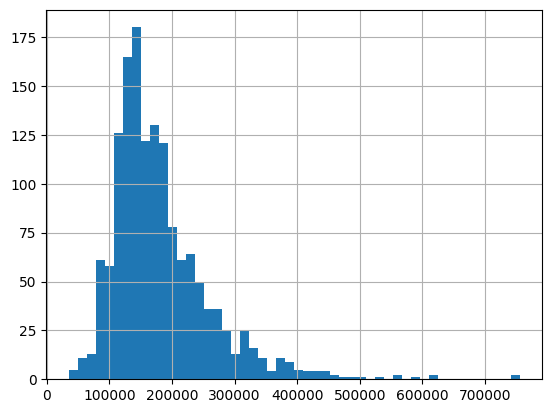

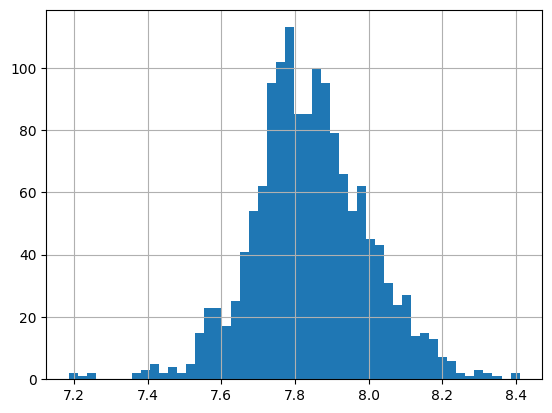

In [2]:
#For Question 1, you can import the following packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame and call it Housing.
#Remember that the first column of the csv file is an index column and not an explanatory variable.
Housing = pd.read_csv('Housing.csv', index_col=0)

#1.b) Determine graphically whether the target variable SalePrice exhibits a Gaussian distribution.
Housing["SalePrice"].hist(bins=50)
plt.show()

#If not, suggest a suitable transformation to bring SalePrice close to a Gaussian distribution (logarithmic, inverse, square-root, ...).
#Do not forget to apply this transformation to the target variable SalePrice in the dataset and perform the regressions of Q2-Q3 on this transformed target.
Housing["SalePrice"] = stats.boxcox(Housing["SalePrice"])[0]
Housing["SalePrice"].hist(bins=50)
plt.show()

#1.c) Use one-hot encoding for the categorical features using the default function pd.get_dummies(...).

#Replace missing numeric values (NaN’s) with the mean of their respective columns using pd.fillna(...).
# Skipped counting NA as a category as I couldn't get it to work, and according to Moodle it won't be penalized.
Numerics = Housing.select_dtypes(include=np.number).columns
Categorics = Housing.select_dtypes(exclude=np.number).columns
Housing[Numerics] = Housing[Numerics].fillna(Housing[Numerics].mean())
Housing[Categorics] = Housing[Categorics].fillna(Housing[Categorics].mode().iloc[0])

Housing = pd.get_dummies(Housing, dtype=float)

#1.d) Create a second pandas DataFrame from Housing without the categorical features (i.e. no more dummy variables). Call it Housing2.
Housing2 = Housing[Numerics].copy()

### Question 2 - Linear Regression on Housing2

In [3]:
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

#2.a) Split the Housing2 data into a training set (X,Y)_train and a test set (X, Y)_test.
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.
Housing2_X = Housing2.drop("SalePrice", axis=1)
Housing2_y = Housing2["SalePrice"]
Housing2_X_train, Housing2_X_test, Housing2_y_train, Housing2_y_test = train_test_split(Housing2_X, Housing2_y, test_size=0.3)

#2.b) Fit a linear regression model on the training dataset (X, Y)_train using the sklearn package.
#Output a table with the name of each feature and the associated regression coefficient.
LinReg = LinearRegression().fit(Housing2_X_train, Housing2_y_train)
Table = pd.DataFrame({"Feature": Housing2_X.columns, "Reg. coeff.": LinReg.coef_})
print("sklearn LinearRegression:\n")
print(Table)

#Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2 of your linear regression model.
Housing2_y_pred_train = LinReg.predict(Housing2_X_train)
MSE_in = mean_squared_error(Housing2_y_train, Housing2_y_pred_train)
R2_in = r2_score(Housing2_y_train, Housing2_y_pred_train)
print("\nIn-sample:")
print(f"- MSE: {MSE_in}")
print(f"- R2: {R2_in}")

Housing2_y_pred_test = LinReg.predict(Housing2_X_test)
MSE_out = mean_squared_error(Housing2_y_test, Housing2_y_pred_test)
R2_out = r2_score(Housing2_y_test, Housing2_y_pred_test)
print("\nOut-of-sample:")
print(f"- MSE: {MSE_out}")
print(f"- R2: {R2_out}")

#2.c) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. Remember that the design matrix A needs to include a column of 1's.
Designmatrix = sm.add_constant(Housing2_X_train)
EstCoeffInv = np.linalg.inv(Designmatrix.T @ Designmatrix) @ Designmatrix.T @ Housing2_y_train
EstTable = pd.DataFrame({"Feature": Housing2_X.columns, "Reg. coeff.": EstCoeffInv[1:]})
print("-"*80)
print("Numpy inversion:\n")
print(EstTable)
print("Intercept: ", EstCoeffInv[0])

#	  (ii) Compute the standard error of each estimated coefficient using the numpy package.
UnderSQRT = np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train)).sum() / (len(Housing2_y_train) - len(EstCoeffInv))
SE = np.sqrt(UnderSQRT * np.diagonal(np.linalg.inv(Designmatrix.T @ Designmatrix)))
# Because the matrix A^T@A is ill-conditioned with small EVs some entries of the diagonal might be negative, which returns NaNs in the sqrt.
# This is addressed below by using pseudoinversion.
print("\nStandard errors:\n", SE)

#     (iii) Compute the (in-sample) MSE and R^2 using the numpy package.
Housing2_y_pred_train_inv = Designmatrix @ EstCoeffInv.to_numpy()
MSE_in_est = np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train_inv)).sum() / len(Housing2_y_train)
R2_in_est = 1 - (np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train_inv)).sum() / np.square(np.subtract(Housing2_y_train, Housing2_y_train.mean())).sum())

#     (iv) Do the results change using pseudoinversion instead of standard matrix inversion in (i) and (ii)?
EstCoeffPseudoInv = np.linalg.pinv(Designmatrix.T @ Designmatrix) @ Designmatrix.T @ Housing2_y_train
EstTable = pd.DataFrame({"Feature": Housing2_X.columns, "Reg. coeff.": EstCoeffPseudoInv[1:]})
print("-"*80)
print("Numpy pseudoinversion:\n")
print(EstTable)
print("Intercept: ", EstCoeffPseudoInv[0])

UnderSQRT = np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train)).sum() / (len(Housing2_y_train) - len(EstCoeffPseudoInv))
SE = np.sqrt(UnderSQRT * np.diagonal(np.linalg.pinv(Designmatrix.T @ Designmatrix)))
print("\nStandard errors:\n", SE)

Housing2_y_pred_train_pinv = Designmatrix @ EstCoeffPseudoInv.to_numpy()
MSE_in_est_pinv = np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train_pinv)).sum() / len(Housing2_y_train)
R2_in_est_pinv = 1 - (np.square(np.subtract(Housing2_y_train, Housing2_y_pred_train_pinv)).sum() / np.square(np.subtract(Housing2_y_train, Housing2_y_train.mean())).sum())

#     (v) Compare your results (i), (ii), (iii) (with and without pseudoinversion) to the output of the sm.OLS function.
smOLS = sm.OLS(Housing2_y_train, Designmatrix).fit()
print("-"*80)
print("MSE:")
print("- sm.OLS:\t", smOLS.mse_resid, "\n- i):\t\t", MSE_in_est, "\n- ii):\t\t", MSE_in_est_pinv)
print("R2:")
print("- sm.OLS:\t", smOLS.rsquared, "\n- i):\t\t", R2_in_est, "\n- ii):\t\t", R2_in_est_pinv)

#ANSWER to 2c) iii) iv)
# The results from using the regular matrix inversion are very different to the ones from the other two methods, which can be attributed to the ill-conditioned matrix A^T@A.
# Using pseudoinversion yields results that are very similar to the ones from sm.OLS, meaning that pseudoinverse is more stable than the regular inverse in this case.

#2.d) Suggest instead a second-order polynomial regression model (including all quadratic and mixed terms) to predict the (transformed) SalePrice.

# Sceond order polynomial regression model
Poly = PolynomialFeatures(degree=2)
Housing2_X_train_poly = Poly.fit_transform(Housing2_X_train)
Housing2_X_test_poly = Poly.fit_transform(Housing2_X_test)

# Fit the model
PolyReg = LinearRegression().fit(Housing2_X_train_poly, Housing2_y_train)
Housing2_y_pred_train_poly = PolyReg.predict(Housing2_X_train_poly)
MSE_in_poly = mean_squared_error(Housing2_y_train, Housing2_y_pred_train_poly)
R2_in_poly = r2_score(Housing2_y_train, Housing2_y_pred_train_poly)
print("-"*80)
print("Second order polynomial regression model:")
print("\nIn-sample:")
print("- MSE: ", MSE_in_poly)
print("- R2: ", R2_in_poly)
Housing2_y_pred_test_poly = PolyReg.predict(Housing2_X_test_poly)
MSE_out_poly = mean_squared_error(Housing2_y_test, Housing2_y_pred_test_poly)
R2_out_poly = r2_score(Housing2_y_test, Housing2_y_pred_test_poly)
print("\nOut-of-sample:")
print(f"- MSE: {MSE_out_poly}")
print(f"- R2: {R2_out_poly}")

#Does this improve the linear regression model 2.b)?
#ANSWER

#The in-sample MSE and R2 are similar or even better for the quadratic model.
#However the out-of-sample MSE and R2 are worse.
#This indicates that the model is overfitting the training data.

#What happens with higher-order polynomial regression models?
Poly = PolynomialFeatures(degree=3)
Housing2_X_train_poly = Poly.fit_transform(Housing2_X_train)
Housing2_X_test_poly = Poly.fit_transform(Housing2_X_test)
#ANSWER
#The in-sample MSE and R2 way better for the cubic model compared to LR
#However the out-of-sample MSE and R2 are worse.
#This indicates that the model is overfitting the training data.

# Fit the model
PolyReg = LinearRegression().fit(Housing2_X_train_poly, Housing2_y_train)
Housing2_y_pred_train_poly = PolyReg.predict(Housing2_X_train_poly)
MSE_in_poly = mean_squared_error(Housing2_y_train, Housing2_y_pred_train_poly)
R2_in_poly = r2_score(Housing2_y_train, Housing2_y_pred_train_poly)
print("-"*80)
print(f"Third order polynomial regression model:")
print("\nIn-sample:")
print("- MSE: ", MSE_in_poly)
print("- R2: ", R2_in_poly)
Housing2_y_pred_test_poly = PolyReg.predict(Housing2_X_test_poly)
MSE_out_poly = mean_squared_error(Housing2_y_test, Housing2_y_pred_test_poly)
R2_out_poly = r2_score(Housing2_y_test, Housing2_y_pred_test_poly)
print("\nOut-of-sample:")
print(f"- MSE: {MSE_out_poly}")
print(f"- R2: {R2_out_poly}")

# The higher the order, the more the model overfits and the better and worse the in-sample and out-of-sample results get, respectively.


sklearn LinearRegression:

          Feature   Reg. coeff.
0      MSSubClass -2.580425e-04
1     LotFrontage -8.879115e-05
2         LotArea  7.489186e-07
3     OverallQual  3.372711e-02
4     OverallCond  2.115928e-02
5       YearBuilt  1.261264e-03
6    YearRemodAdd  2.719097e-04
7      MasVnrArea  3.529168e-06
8      BsmtFinSF1  7.050933e-06
9      BsmtFinSF2  1.467912e-05
10      BsmtUnfSF -2.406973e-06
11    TotalBsmtSF  1.932308e-05
12       1stFlrSF  2.848467e-05
13       2ndFlrSF  1.334140e-05
14   LowQualFinSF  6.221087e-06
15      GrLivArea  4.804716e-05
16   BsmtFullBath  2.559902e-02
17   BsmtHalfBath  2.622506e-03
18       FullBath  2.195677e-02
19       HalfBath  9.190598e-03
20   BedroomAbvGr  1.530487e-03
21   KitchenAbvGr -2.167604e-02
22   TotRmsAbvGrd  5.912908e-03
23     Fireplaces  1.638174e-02
24    GarageYrBlt -8.656014e-05
25     GarageCars  3.527756e-02
26     GarageArea -1.584098e-05
27     WoodDeckSF  4.224824e-05
28    OpenPorchSF  6.289113e-05
29  EnclosedP

<ipython-input-3-5b45bdd3eabb>:46: RuntimeWarning: invalid value encountered in sqrt
  SE = np.sqrt(UnderSQRT * np.diagonal(np.linalg.inv(Designmatrix.T @ Designmatrix)))


--------------------------------------------------------------------------------
Second order polynomial regression model:

In-sample:
- MSE:  0.0008843871764074885
- R2:  0.9649963459609932

Out-of-sample:
- MSE: 0.06543404191286398
- R2: -1.7012826785302266
--------------------------------------------------------------------------------
Third order polynomial regression model:

In-sample:
- MSE:  1.1653949575232227e-18
- R2:  1.0

Out-of-sample:
- MSE: 17045.836062364684
- R2: -703694.2074219839


### Question 3 - Regularization techniques on Housing

In [5]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold
from numpy.linalg import svd

#3.a) Perform again a linear regression for the (transformed) SalePrice using this time the full Housing DataFrame.

Housing2_X_train_indices = Housing2_X_train.index
Housing2_X_test_indices = Housing2_X_test.index
Housing_X = Housing.drop("SalePrice", axis=1)
Housing_y = Housing["SalePrice"]

# Use same observations as in Q2
Housing_X_train = Housing_X.loc[Housing2_X_train_indices]
Housing_X_test = Housing_X.loc[Housing2_X_test_indices]
Housing_y_train = Housing_y.loc[Housing2_X_train_indices]
Housing_y_test = Housing_y.loc[Housing2_X_test_indices]

LinReg = LinearRegression().fit(Housing_X_train, Housing_y_train)
Table = pd.DataFrame({"Feature": Housing_X.columns, "Reg. coeff.": LinReg.coef_})
print("sklearn LinearRegression:\n")
print(Table)

Housing_y_pred_train = LinReg.predict(Housing_X_train)
MSE_in = mean_squared_error(Housing_y_train, Housing_y_pred_train)
R2_in = r2_score(Housing_y_train, Housing_y_pred_train)
print("\nIn-sample:")
print(f"- MSE: {MSE_in}")
print(f"- R2: {R2_in}")

Housing_y_pred_test = LinReg.predict(Housing_X_test)
MSE_out = mean_squared_error(Housing_y_test, Housing_y_pred_test)
R2_out = r2_score(Housing_y_test, Housing_y_pred_test)
print("\nOut-of-sample:")
print(f"- MSE: {MSE_out}")
print(f"- R2: {R2_out}")

#How do the in-sample and out-of-sample MSE and R^2 metrics compare to the results of Question 2.b) on the Housing2 DataFrame?

# The in-sample results are better, since more features are included, but the out-of-sample results are worse, since the model is overfitting the training data.
# This can be helped by using regularization techniques to select the most important features.

#3.b)  Implement the truncated pseudoinverse, Ridge and Lasso regularization techniques.
# Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the R^2 metric.

# define A-matrix from Housing_X_train and columns of one's
A_train = np.hstack((np.ones((Housing_X_train.shape[0], 1)), Housing_X_train))
A_test = np.hstack((np.ones((Housing_X_test.shape[0], 1)), Housing_X_test))

# initialize variables with numpy's svd
U, S, Vh = svd(A_train, full_matrices=True)

Sc = np.zeros_like(S)
c= 6                            # set c as parameter for truncation
Sc[S > c] = 1/S[S > c]          # use bool-indexing to access the singular values that are big enouogh and invert them
Sc_mat = np.diagflat(Sc)        # use np.diagflat to initialize a 2d array (diagaonal matrix) from a 1d array

# zero-padding: append 1022 - 280 0-columns to the right of Sc_mat
dim1, dim2 = U.shape, Sc_mat.shape
rows1, cols1 = dim1
rows2, cols2 = dim2
zero_pad = np.zeros((rows2, cols1-cols2))
Sc_mat = np.hstack((Sc_mat, zero_pad))

# compute coefficients
beta = Vh.transpose() @ Sc_mat @ U.transpose() @ Housing_y_train
MSE_trunc_in, MSE_trunc_out = mean_squared_error(Housing_y_train, A_train @ beta), mean_squared_error(Housing_y_test, A_test @ beta)
R2_trunc_in, R2_trunc_out = r2_score(Housing_y_train, A_train @ beta), r2_score(Housing_y_test, A_test @ beta)

print("\nIn-Sample-truncated-pseudo-inverse: ")
print(f'MSE: {MSE_trunc_in}')
print(f'R2: {R2_trunc_in}')

print("\nOut-of-Sample-truncated-pseudo-inverse: ")
print(f'MSE: {MSE_trunc_out}')
print(f'R2: {R2_trunc_out}')


RidgeReg = Ridge()
LassoReg = Lasso()
cv = RepeatedKFold(n_splits=8, n_repeats=1)

RidgeScores = []
LassoScores = []
Alphas = np.logspace(-3, 3, 50)

for alpha in Alphas:
    RidgeReg.set_params(alpha=alpha)
    LassoReg.set_params(alpha=alpha)
    RidgeCVScores = cross_val_score(RidgeReg, Housing_X_train, Housing_y_train, scoring='r2', cv=cv)
    LassoCVScores = cross_val_score(LassoReg, Housing_X_train, Housing_y_train, scoring='r2', cv=cv)
    RidgeScores.append(RidgeCVScores.mean())
    LassoScores.append(LassoCVScores.mean())

BestAlphaRidge = Alphas[np.argmax(RidgeScores)]
BestAlphaLasso = Alphas[np.argmax(LassoScores)]

RidgeReg.set_params(alpha=BestAlphaRidge)
LassoReg.set_params(alpha=BestAlphaLasso)

RidgeReg.fit(Housing_X_train, Housing_y_train)
LassoReg.fit(Housing_X_train, Housing_y_train)

Table = pd.DataFrame({"Feature": Housing_X.columns, "Ridge coeff.": RidgeReg.coef_, "Lasso coeff.": LassoReg.coef_})
print("\nRidge and Lasso:\n")
print(Table)

# Compare their performance in terms of in-sample and out-of-sample MSE with the linear regressions of Questions 2.b) and 3.a).

Housing_y_pred_train_ridge = RidgeReg.predict(Housing_X_train)
MSE_in_ridge = mean_squared_error(Housing_y_train, Housing_y_pred_train_ridge)
R2_in_ridge = r2_score(Housing_y_train, Housing_y_pred_train_ridge)
print("\nIn-sample Ridge:")
print(f"- MSE: {MSE_in_ridge}")
print(f"- R2: {R2_in_ridge}")

Housing_y_pred_test_ridge = RidgeReg.predict(Housing_X_test)
MSE_out_ridge = mean_squared_error(Housing_y_test, Housing_y_pred_test_ridge)
R2_out_ridge = r2_score(Housing_y_test, Housing_y_pred_test_ridge)
print("\nOut-of-sample Ridge:")
print(f"- MSE: {MSE_out_ridge}")
print(f"- R2: {R2_out_ridge}")

Housing_y_pred_train_lasso = LassoReg.predict(Housing_X_train)
MSE_in_lasso = mean_squared_error(Housing_y_train, Housing_y_pred_train_lasso)
R2_in_lasso = r2_score(Housing_y_train, Housing_y_pred_train_lasso)
print("\nIn-sample Lasso:")
print(f"- MSE: {MSE_in_lasso}")
print(f"- R2: {R2_in_lasso}")

Housing_y_pred_test_lasso = LassoReg.predict(Housing_X_test)
MSE_out_lasso = mean_squared_error(Housing_y_test, Housing_y_pred_test_lasso)
R2_out_lasso = r2_score(Housing_y_test, Housing_y_pred_test_lasso)
print("\nOut-of-sample Lasso:")
print(f"- MSE: {MSE_out_lasso}")
print(f"- R2: {R2_out_lasso}")

#3.c) For the  Lasso regularization technique, how many coefficients are non-zero?

print("\nNumber of non-zero coefficients in Lasso: ", np.count_nonzero(LassoReg.coef_), " out of ", len(LassoReg.coef_))

#Compare this number with the number of coefficients retained by the Ridge and truncated pseudoinverse techniques and provide an explanation.
print("\nNumber of non-zero coefficients in Ridge: ", np.count_nonzero(RidgeReg.coef_), " out of ", len(RidgeReg.coef_))
print("\nNumber of non-zero coefficients in Truncated Pseudoinverse: ", np.count_nonzero(beta), " out of ", len(beta))
#ANSWER
# Ridge doesn't set coefficients to zero, it only shrinks them.
#The reason for that is that we minimize the L1 norm in Lasso that's why there are many zero entries.
#However in Ridge we minimise the L2 norm, therefore the coefficients get sometimes very small but do not necessarily equal to zero.
#For the truncated Pseudoinverse there is no restriction on the norm of the coefficients itself. Therefore no sparse property.

#3.d) Based on your findings from Questions 2 and 3, which model would you recommend? Justify your choice.
#ANSWER
#We saw in Ex2. that polynomial regression is overfitting the data.
#Linear Regression: using directly the inverse does not yield good solutions.

#Regularization against overfitting:
#All three regularisation methods yield better R2 values (they are closer to 1) and lower MSE values (closer to 0) compared to Linear Regression.
#The values are quite similar across all three methods and there is no sign of overfitting as the R² value in-sample and out-sample are similar.
#However, the best MSE and R² values delivers Ridge regression.
#The only disadvantage in the three methods is the determination of the right parameters, alpha for ridge and lasso,and c for the truncated pseudo inverse method.
#which are equally hard to determine.
#Lasso yields a sparse coefficient vector, meaning that the underlying model is simpler compared to ridge and especially truncated pseudoinverse.
#

#Therefore we recommend:
#Ridge regression, the coefficient vector has less nnz's and is kind of sparse, but still performs well looking at R² and MSE.

sklearn LinearRegression:

                   Feature   Reg. coeff.
0               MSSubClass -1.293573e-04
1              LotFrontage  2.114304e-04
2                  LotArea  9.557000e-07
3              OverallQual  1.637125e-02
4              OverallCond  1.478176e-02
..                     ...           ...
282  SaleCondition_AdjLand -1.123446e-02
283   SaleCondition_Alloca -2.853884e-03
284   SaleCondition_Family  2.487192e-02
285   SaleCondition_Normal  5.675104e-03
286  SaleCondition_Partial  5.743626e-03

[287 rows x 2 columns]

In-sample:
- MSE: 0.0013230899254155978
- R2: 0.9476326848158596

Out-of-sample:
- MSE: 0.003402105320221207
- R2: 0.8595524912814172

In-Sample-truncated-pseudo-inverse: 
MSE: 0.0024776583842872884
R2: 0.9019353748855392

Out-of-Sample-truncated-pseudo-inverse: 
MSE: 0.003513689121350052
R2: 0.8549460298680247

Ridge and Lasso:

                   Feature  Ridge coeff.  Lasso coeff.
0               MSSubClass -1.864250e-04 -2.403718e-04
1             